In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 536 images belonging to 2 classes.
Found 168 images belonging to 2 classes.

[INFO] Epoch 1/10
Train loss: 0.5349 - Train accuracy: 0.6996
Val loss: 0.3906 - Val accuracy: 0.7738

[INFO] Epoch 2/10
Train loss: 0.2068 - Train accuracy: 0.8638
Val loss: 0.3959 - Val accuracy: 0.8036

[INFO] Epoch 3/10
Train loss: 0.1665 - Train accuracy: 0.8806
Val loss: 0.2620 - Val accuracy: 0.8810

[INFO] Epoch 4/10
Train loss: 0.1154 - Train accuracy: 0.9235
Val loss: 0.4989 - Val accuracy: 0.7619

[INFO] Epoch 5/10
Train loss: 0.1094 - Train accuracy: 0.9254
Val loss: 0.2090 - Val accuracy: 0.9405

[INFO] Epoch 6/10
Train loss: 0.1013 - Train accuracy: 0.9403
Val loss: 0.2768 - Val accuracy: 0.8988

[INFO] Epoch 7/10
Train loss: 0.0910 - Train accuracy: 0.9459
Val loss: 0.4563 - Val accuracy: 0.8274

[INFO] Epoch 8/10
Train loss: 0.0760 - Train accuracy: 0.9590
Val loss: 0.2251 - Val accuracy: 0.9405

[INFO] Epoch 9/10
Train loss: 0.0869 - Train accuracy: 0.9515
Val loss: 0.2132 - Val accuracy

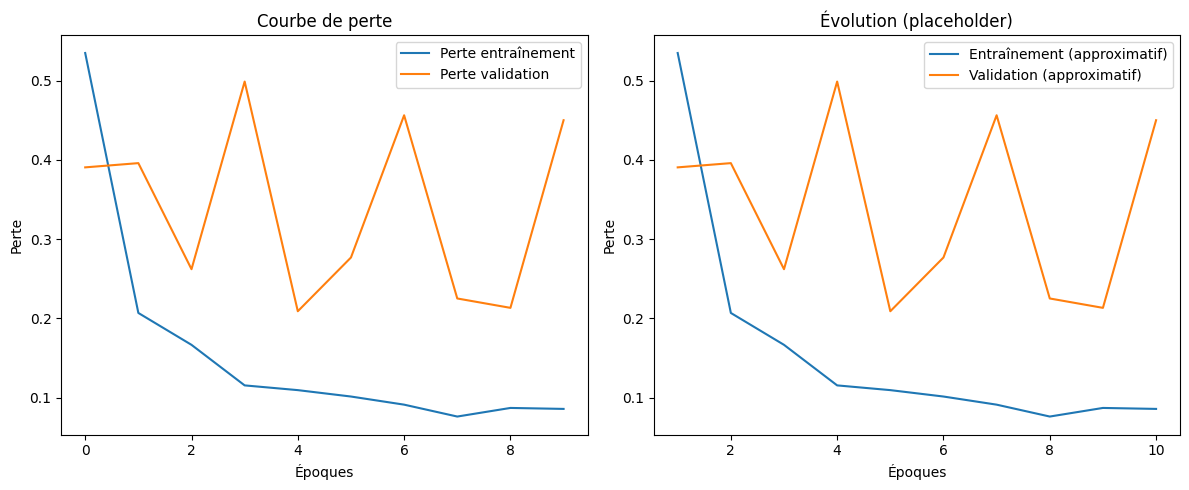

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Paramètres
image_size = (224, 224)
batch_size = 32
epochs = 10
alpha = 0.45  # pondération de la perte de distillation
temperature = 5.0

# Chargement du modèle enseignant
teacher_model_path = '/content/drive/MyDrive/Myresults/Acrima_MobileNetV2_TEACHER.hdf5'
teacher_model = load_model(teacher_model_path, compile=False)
teacher_model.trainable = False

# Prétraitement des images
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/datasets/Acrima_dataset/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/datasets/Acrima_dataset/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes

# Modèle étudiant
def create_student_model():
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

student_model = create_student_model()

# Optimiseur
optimizer = tf.keras.optimizers.Adam()

# Fonction de perte
loss_fn = tf.keras.losses.CategoricalCrossentropy()
kl_div = tf.keras.losses.KLDivergence()

# Métriques
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

# Entraînement personnalisé
train_loss_results = []
val_loss_results = []

@tf.function
def train_step(images, labels):
    teacher_preds = teacher_model(images, training=False)

    with tf.GradientTape() as tape:
        student_preds = student_model(images, training=True)

        # Hard loss
        hard_loss = loss_fn(labels, student_preds)

        # Soft targets
        teacher_soft = tf.nn.softmax(teacher_preds / temperature)
        student_soft = tf.nn.softmax(student_preds / temperature)

        # Distillation loss (KLD entre logits "soft")
        distill_loss = kl_div(teacher_soft, student_soft) * (temperature ** 2)

        # Total loss
        loss = alpha * distill_loss + (1 - alpha) * hard_loss

    gradients = tape.gradient(loss, student_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

    train_acc_metric.update_state(labels, student_preds)
    return loss

@tf.function
def test_step(images, labels):
    preds = student_model(images, training=False)
    loss = loss_fn(labels, preds)
    val_acc_metric.update_state(labels, preds)
    return loss

# Boucle d'entraînement
for epoch in range(epochs):
    print(f"\n[INFO] Epoch {epoch + 1}/{epochs}")
    total_loss = 0.0
    total_val_loss = 0.0
    batches = 0

    # Boucle d'entraînement
    for images, labels in train_generator:
        loss = train_step(images, labels)
        total_loss += loss
        batches += 1
        if batches >= len(train_generator):
            break

    train_loss_results.append(total_loss / batches)
    train_acc = train_acc_metric.result()
    print(f"Train loss: {train_loss_results[-1]:.4f} - Train accuracy: {train_acc:.4f}")
    train_acc_metric.reset_state()

    # Boucle de validation
    batches = 0
    for val_images, val_labels in test_generator:
        val_loss = test_step(val_images, val_labels)
        total_val_loss += val_loss
        batches += 1
        if batches >= len(test_generator):
            break

    val_loss_results.append(total_val_loss / batches)
    val_acc = val_acc_metric.result()
    print(f"Val loss: {val_loss_results[-1]:.4f} - Val accuracy: {val_acc:.4f}")
    val_acc_metric.reset_state()

# Affichage des courbes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_results, label='Perte entraînement')
plt.plot(val_loss_results, label='Perte validation')
plt.title("Courbe de perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([None] + train_loss_results, label='Entraînement (approximatif)')
plt.plot([None] + val_loss_results, label='Validation (approximatif)')
plt.title("Évolution (placeholder)")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 895ms/step - accuracy: 0.8522 - loss: 0.4848
[INFO] Test Loss: 0.4922 | Test Accuracy: 0.8512
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step

[INFO] Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.48      0.96      0.64        23
      Normal       0.99      0.83      0.91       145

    accuracy                           0.85       168
   macro avg       0.74      0.90      0.77       168
weighted avg       0.92      0.85      0.87       168



<Figure size 600x600 with 0 Axes>

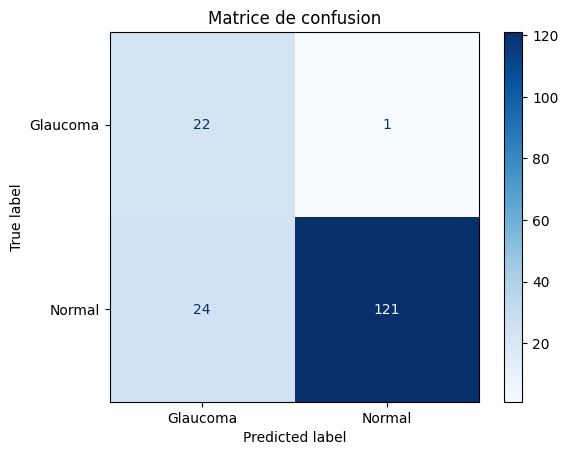

In [ ]:
# Évaluation finale
# Compilation du modèle AVANT l'évaluation
student_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Évaluation
loss, accuracy = student_model.evaluate(test_generator)
print(f"[INFO] Test Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f}")

# Prédictions
Y_pred = student_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Rapport et matrice de confusion
print("\n[INFO] Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

student_model.save("/content/drive/MyDrive/Myresults/Acrima_MobileNetV2_STUDENT2.hdf5")